### The German Traffic Sign Benchmark

Student Name 1: ...

Student Name 2: ...

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
!wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2019-04-08 09:59:11--  http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
Resolving benchmark.ini.rub.de (benchmark.ini.rub.de)... 134.147.122.15
Connecting to benchmark.ini.rub.de (benchmark.ini.rub.de)|134.147.122.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  6.08MB/s    in 3m 1s   

2019-04-08 10:02:12 (8.76 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN201

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)#(224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

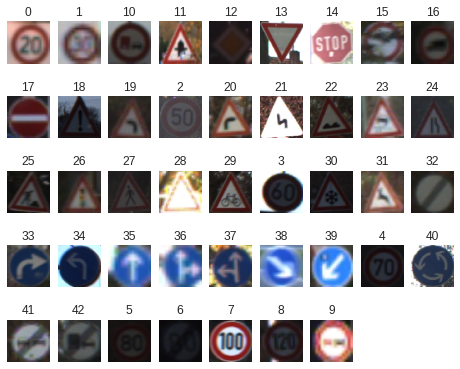

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.3: Transfer learning

In [0]:
def extract_bottleneck_features(initial_model, output_layer_name, output_shape):
    batch_size = 16
    
    flatten_feature_shape = output_shape[0]*output_shape[1]*output_shape[2]
    
    tr_signs_f = np.empty([tr_signs.shape[0], flatten_feature_shape])
    tr_labels_f = np.empty([tr_labels.shape[0], num_classes])
    
    va_signs_f = np.empty([va_signs.shape[0], flatten_feature_shape])
    va_labels_f = np.empty([va_labels.shape[0], num_classes])
    
    te_signs_f = np.empty([te_signs.shape[0], flatten_feature_shape])
    te_labels_f = np.empty([te_labels.shape[0], num_classes])
    
    print("flatten shape:", flatten_feature_shape)
    
    feature_extractor = Model(inputs=initial_model.input, outputs=initial_model.get_layer(output_layer_name).output)
    
    # train dataset feature extraction
    for i in range(tr_signs.shape[0]):
        img = np.expand_dims(tr_signs[i], axis=0) # take sample 
        feature = feature_extractor.predict(img, batch_size=batch_size) # extract features
        tr_signs_f[i] = feature.flatten()
        tr_labels_f[i] = tr_labels[i]
    
    # validation dataset feature extraction
    for i in range(va_signs.shape[0]):
        img = np.expand_dims(va_signs[i], axis=0) # take sample 
        feature = feature_extractor.predict(img, batch_size=batch_size) # extract features
        va_signs_f[i] = feature.flatten()
        va_labels_f[i] = va_labels[i]
        
    # test dataset feature extraction
    for i in range(te_signs.shape[0]):
        img = np.expand_dims(te_signs[i], axis=0) # take sample 
        feature = feature_extractor.predict(img, batch_size=batch_size) # extract features
        te_signs_f[i] = feature.flatten()
        te_labels_f[i] = te_labels[i]
        
    return tr_signs_f,tr_labels_f,va_signs_f,va_labels_f,te_signs_f,te_labels_f


 <h3>NasNetMobile</h3>

In [48]:
from keras import applications
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization, Activation, Flatten
from keras.models import Model

# ------------------- NASnetMobile
feature_extractor = applications.nasnet.NASNetMobile(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), include_top=False, weights='imagenet')
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)
feature_extractor_model = Model(inputs=feature_extractor.input, outputs=predictions)

19996672/19993432 [==============================] - 0s 0us/step


In [49]:
from keras.optimizers import Adam

# compile feature extractor model
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
feature_extractor_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
feature_extractor_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 111, 111, 32) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

In [52]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
datagen.fit(tr_signs, augment=True)

train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = feature_extractor_model.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=16), epochs=60, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard])

start = time()
loss, acc = feature_extractor_model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('Model took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Epoch 1/10
 - 26s - loss: 0.0298 - acc: 0.9932 - val_loss: 1.1323 - val_acc: 0.7698
Epoch 2/10
 - 25s - loss: 0.0474 - acc: 0.9899 - val_loss: 1.3911 - val_acc: 0.6667
Epoch 3/10
 - 25s - loss: 0.0153 - acc: 0.9949 - val_loss: 6.2362 - val_acc: 0.2262
Epoch 4/10
 - 25s - loss: 0.0242 - acc: 0.9949 - val_loss: 3.3235 - val_acc: 0.3810
Epoch 5/10
 - 25s - loss: 0.1155 - acc: 0.9780 - val_loss: 4.5089 - val_acc: 0.3889
Epoch 6/10
 - 25s - loss: 0.0721 - acc: 0.9797 - val_loss: 3.9896 - val_acc: 0.4087
Epoch 7/10
 - 25s - loss: 0.0298 - acc: 0.9916 - val_loss: 2.1186 - val_acc: 0.6032
Epoch 8/10
 - 25s - loss: 0.0111 - acc: 0.9966 - val_loss: 1.6775 - val_acc: 0.7103
Epoch 9/10
 - 25s - loss: 0.0033 - acc: 1.0000 - val_loss: 1.4133 - val_acc: 0.7381
Epoch 10/10
 - 25s - loss: 0.0763 - acc: 0.9882 - val_loss: 2.6146 - val_acc: 0.6706
Model took 1.9815433025360107 seconds
Test loss: 2.3430742309364256 - Accuracy: 0.6454293630459963


In [53]:
start = time()
loss, acc = feature_extractor_model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('Model took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))



Model took 2.080441951751709 seconds
Test loss: 2.3430742309364256 - Accuracy: 0.6454293630459963


In [0]:
feature_extractor_model.save_weights('dense201_feature_extractor_weights.h5')

In [54]:
for i, layer in enumerate(feature_extractor_model.layers):
    print(i, layer.name)

0 input_6
1 stem_conv1
2 stem_bn1
3 activation_7
4 reduction_conv_1_stem_1
5 reduction_bn_1_stem_1
6 activation_8
7 activation_10
8 separable_conv_1_pad_reduction_left1_stem_1
9 separable_conv_1_pad_reduction_right1_stem_1
10 separable_conv_1_reduction_left1_stem_1
11 separable_conv_1_reduction_right1_stem_1
12 separable_conv_1_bn_reduction_left1_stem_1
13 separable_conv_1_bn_reduction_right1_stem_1
14 activation_9
15 activation_11
16 separable_conv_2_reduction_left1_stem_1
17 separable_conv_2_reduction_right1_stem_1
18 activation_12
19 separable_conv_2_bn_reduction_left1_stem_1
20 separable_conv_2_bn_reduction_right1_stem_1
21 separable_conv_1_pad_reduction_right2_stem_1
22 activation_14
23 reduction_add_1_stem_1
24 separable_conv_1_reduction_right2_stem_1
25 separable_conv_1_pad_reduction_right3_stem_1
26 activation_16
27 separable_conv_1_bn_reduction_right2_stem_1
28 separable_conv_1_reduction_right3_stem_1
29 separable_conv_1_reduction_left4_stem_1
30 activation_13
31 separable_con

In [56]:
print(feature_extractor_model.layers[-3].output_shape[1:])

print(feature_extractor_model.layers[-3].name)

(7, 7, 1056)
activation_194


In [57]:
#extract features
tr_signs_f, tr_labels_f, va_signs_f, va_labels_f, te_signs_f, te_labels_f = extract_bottleneck_features(feature_extractor_model, feature_extractor_model.layers[-3].name, feature_extractor_model.layers[-3].output_shape[1:])



flatten shape: 51744


In [42]:
print(tr_signs_f.shape)

(600, 25088)


In [58]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Model,Sequential
from keras import optimizers


model = Sequential()
model.add(Dense(1024, input_shape = (tr_signs_f.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# optimization
#opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
opt = optimizers.Adam(lr=0.001)
#opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
#opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1024)              52986880  
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_195 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_196 (Activation)  (None, 1024)              0         
__________

<h2>Training smaller network by using extracted features as input dataset</h2>

<h3>Standard training technique</h3>

In [59]:
data = model.fit(tr_signs_f, tr_labels_f, epochs=20, batch_size=32, validation_data=(va_signs_f, va_labels_f), verbose=2, callbacks=[tensorboard])

Train on 600 samples, validate on 252 samples
Epoch 1/20
 - 8s - loss: 1.4800 - acc: 0.6650 - val_loss: 0.6697 - val_acc: 0.8690
Epoch 2/20
 - 2s - loss: 0.5063 - acc: 0.8817 - val_loss: 0.4796 - val_acc: 0.8929
Epoch 3/20
 - 2s - loss: 0.2461 - acc: 0.9367 - val_loss: 0.3890 - val_acc: 0.9246
Epoch 4/20
 - 2s - loss: 0.1512 - acc: 0.9667 - val_loss: 0.3354 - val_acc: 0.9167
Epoch 5/20
 - 2s - loss: 0.1358 - acc: 0.9667 - val_loss: 0.3390 - val_acc: 0.9167
Epoch 6/20
 - 2s - loss: 0.0668 - acc: 0.9883 - val_loss: 0.3454 - val_acc: 0.9167
Epoch 7/20
 - 2s - loss: 0.0517 - acc: 0.9917 - val_loss: 0.3418 - val_acc: 0.9206
Epoch 8/20
 - 2s - loss: 0.0361 - acc: 0.9950 - val_loss: 0.3360 - val_acc: 0.9167
Epoch 9/20
 - 2s - loss: 0.0253 - acc: 0.9933 - val_loss: 0.3242 - val_acc: 0.9206
Epoch 10/20
 - 2s - loss: 0.0193 - acc: 0.9967 - val_loss: 0.3361 - val_acc: 0.9206
Epoch 11/20
 - 2s - loss: 0.0189 - acc: 0.9983 - val_loss: 0.3376 - val_acc: 0.9167
Epoch 12/20
 - 2s - loss: 0.0175 - acc:

In [60]:
start = time()
loss, acc = model.evaluate(te_signs_f, te_labels_f, verbose=0)
end = time()
print('Model took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Model took 0.30207014083862305 seconds
Test loss: 0.1417293225949078 - Accuracy: 0.9667590027700831


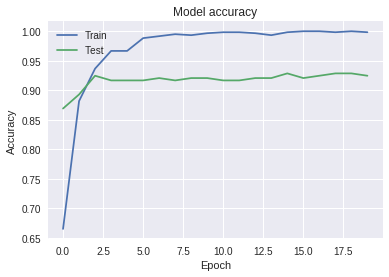

In [61]:
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


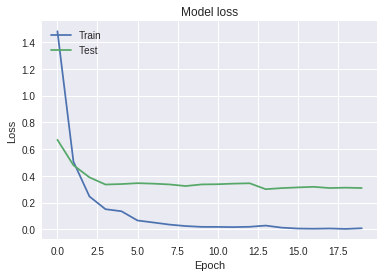

In [62]:
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()